### Importing libraries

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import pprint
%matplotlib inline

### Transfer Learning

In [2]:
tf.random.set_seed(215)
pp = pprint.PrettyPrinter(indent=4)
size_img = 400
vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(size_img, size_img, 3),
                                weights='Pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg.trainable = False
pp.pprint(vgg)

### Example images

Content


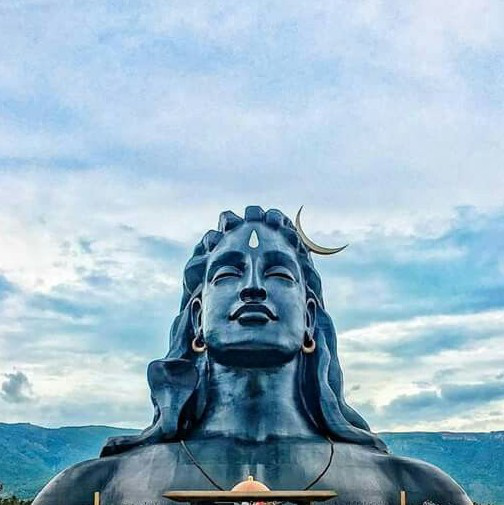

In [3]:
content_image = Image.open('Images/C_image4.jpg')
print('Content')
content_image

Style


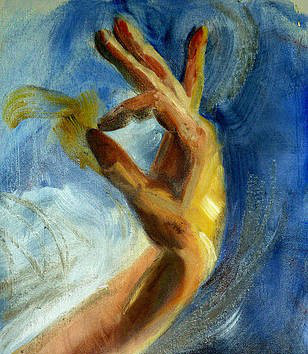

In [4]:
example = Image.open('Images/S_image5.jpg')
print('Style')
example

### Some usefull functions

In [5]:
def content_J(content_output, generated_output):
    
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[-1, n_C])
    
    J_content = (1 / (4*n_H*n_W*n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

In [6]:
def gram_matrix(a):
    
    GA = tf.matmul(a, tf.transpose(a))
    
    return GA

In [7]:
def layer_style_J(a_S, a_G):
    
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape = [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape = [n_H * n_W, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = 1/(4*n_C**2*(n_H*n_W)**2) * (tf.reduce_sum(tf.square(tf.subtract(GS, GG))))
    
    return J_style_layer

In [8]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [10]:
style_layers = [('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [11]:
def style_J(style_image_output, generated_image_output, style_layers=style_layers):
    
    J_style = 0
    
    a_S = style_image_output[:-1]
    
    a_G = generated_image_output[:-1]
    
    for i, weight in zip(range(len(a_S)), style_layers):
        
        J_style_layer = layer_style_J(a_S[i], a_G[i])
        
        J_style += weight[1] * J_style_layer
        
    return J_style

In [12]:
@tf.function
def total_cost(J_content, J_style, alpha=10, beta=40):
    
    J = alpha * J_content + beta * J_style
    
    return J

### Picking an image and a style

(1, 400, 400, 3)


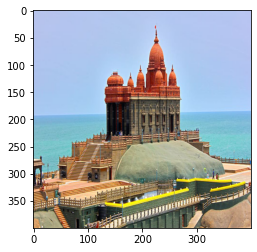

In [123]:
content_image = np.array(Image.open('Images/C_image10.jpg').resize((size_img, size_img)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


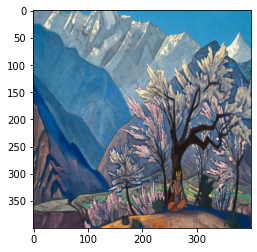

In [128]:
style_image = np.array(Image.open('Images/S_image6.jpg').resize((size_img,size_img)))
style_image = tf.constant(np.reshape(style_image, (1,) + style_image.shape))
print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


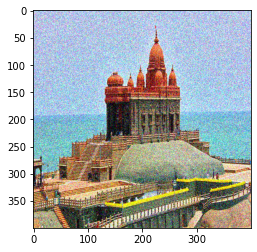

In [129]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

### Processing content, style and generated images

In [130]:
def get_layer_output(vgg, layer_names):
    
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    
    return model

In [132]:
style_layers = [('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2),
    ('block5_conv4', 1)]

In [133]:
vgg_model_outputs = get_layer_output(vgg, style_layers)

In [134]:
print(vgg_model_outputs)

In [135]:
content_target = vgg_model_outputs(content_image)
style_target = vgg_model_outputs(style_image)

In [136]:
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [137]:
def clip(image):
    
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0) 

In [138]:
def tensor_to_image(tensor):
    
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [139]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

In [140]:
@tf.function()
def train(generated_image):
    
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        
        J_style = style_J(a_S, a_G)
        
        J_content = content_J(a_C, a_G)
        
        J = total_cost(J_content, J_style)
        
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip(generated_image))
    
    return J

In [141]:
generated_image = tf.Variable(generated_image)

### Training the model and getting results

Epoch 0


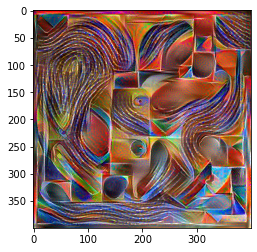

In [66]:
epochs = 6000
for i in range(epochs):
    train(generated_image)
    if i % 250 == 0:
        print(f'Epoch {i}')
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f'Images/G_{i}.jpg')
        plt.show()

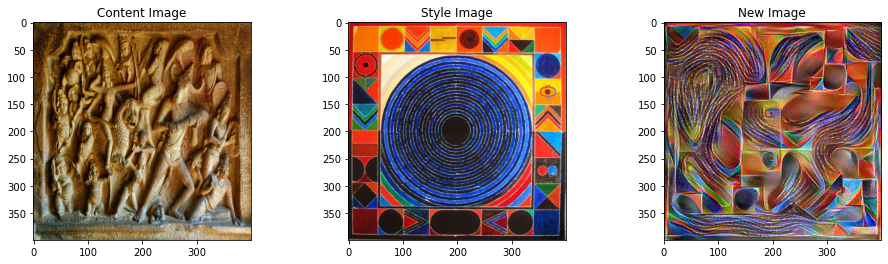

In [67]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)
imshow(content_image[0])
ax.title.set_text('Content Image')
ax = fig.add_subplot(1,3,2)
imshow(style_image[0])
ax.title.set_text('Style Image')
ax = fig.add_subplot(1,3,3)
imshow(generated_image[0])
ax.title.set_text('New Image')
plt.show()

Epoch 0


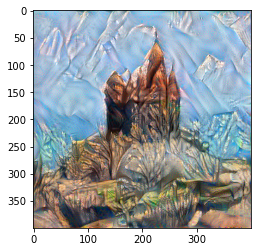

Epoch 1000


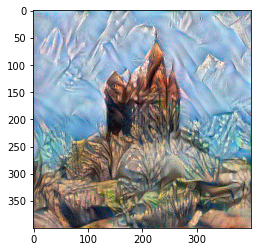

In [95]:
epochs = 6001
for i in range(epochs):
    train(generated_image)
    if i % 1000 == 0:
        print(f'Epoch {i}')
    if i % 1000 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f'Images/G_{i}.jpg')
        plt.show()

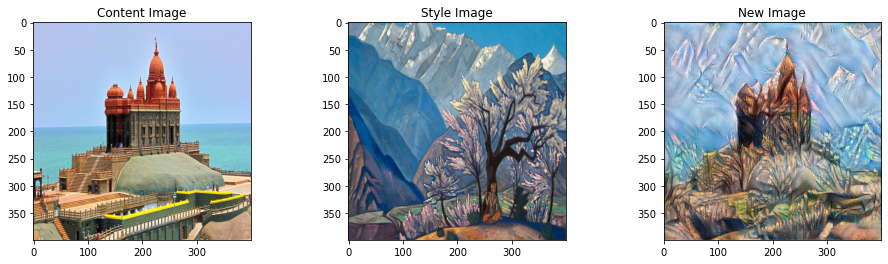

In [96]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)
imshow(content_image[0])
ax.title.set_text('Content Image')
ax = fig.add_subplot(1,3,2)
imshow(style_image[0])
ax.title.set_text('Style Image')
ax = fig.add_subplot(1,3,3)
imshow(generated_image[0])
ax.title.set_text('New Image')
plt.show()